# Predicting Drug-Induced Liver Injury (DILI) Using Machine Learning

## 1. Introduction

Drug-induced liver injury (DILI) is one of the most important safety concerns in drug development. Many promising compounds fail late in the pipeline because liver toxicity is only detected during animal studies or human trials, after years of investment. These late-stage failures are costly, time-consuming, and can expose patients to serious risk.

Traditional hepatotoxicity assessment relies heavily on **in vivo** experiments and clinical observations. While essential, these approaches are:

- Expensive and slow to scale to thousands of candidate molecules.
- Limited in their ability to fully capture human-specific toxicity.
- Constrained by ethical and regulatory considerations around animal testing.

As a result, pharmaceutical teams are increasingly looking for **computational approaches** that can flag high-risk compounds much earlier in the discovery process.

In this project, we explore whether **molecular descriptors**—such as LogP, molecular weight, hydrogen bond donors/acceptors, and structural features—can be used to predict the likelihood that a compound will cause liver injury. Using these features, we build and compare several **machine learning classification models** to distinguish between:

- **SAFE** compounds (lower DILI risk)
- **TOXIC** compounds (higher DILI risk)

Although the dataset used here is **synthetic and simulated for demonstration**, the workflow mirrors how a real-world DILI prediction pipeline could be designed:

- Understand the problem and business impact.
- Explore and analyze molecular features related to toxicity.
- Train and evaluate multiple ML models (e.g., Logistic Regression, Random Forest, Gradient Boosting, XGBoost).
- Identify the most important features driving toxicity risk.
- Package a reusable model that can screen new compounds in seconds.

This notebook showcases how machine learning can support safer, faster, and more cost-effective decision-making in early drug discovery by prioritizing compounds with a lower predicted risk of liver injury.


In [ ]:
import numpy as np
import pandas as pd

def generate_synthetic_dili_dataset(
    n_samples: int = 2000,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Generate a synthetic dataset mimicking molecular properties and DILI risk.

    Parameters
    ----------
    n_samples : int
        Number of compounds to simulate.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        DataFrame with molecular descriptors and binary DILI_Risk label.
    """
    np.random.seed(random_state)

    # Molecular descriptors
    logp = np.round(np.random.uniform(-2, 6, n_samples), 2)                   # lipophilicity
    molecular_weight = np.round(np.random.uniform(100, 800, n_samples), 2)    # Da
    h_bond_donors = np.random.randint(0, 11, n_samples)
    h_bond_acceptors = np.random.randint(0, 16, n_samples)
    rotatable_bonds = np.random.randint(0, 21, n_samples)
    aromatic_rings = np.random.randint(0, 7, n_samples)

    # Simple rule-based CYP3A4 substrate flag
    cyp3a4_substrate = (
        (logp > 1.5) &
        (molecular_weight > 200) &
        (molecular_weight < 600)
    ).astype(int)

    # Latent DILI risk score (linear combination + noise)
    dili_risk_score = (
        0.25 * (logp / 6)
        + 0.20 * (molecular_weight / 800)
        + 0.20 * cyp3a4_substrate
        + 0.15 * (rotatable_bonds / 20)
        + 0.10 * (aromatic_rings / 6)
        - 0.10 * (h_bond_donors / 10)
    )

    dili_risk_score += np.random.normal(0, 0.15, n_samples)

    # Binary label: 1 = TOXIC, 0 = SAFE
    dili_label = (dili_risk_score > 0.4).astype(int)

    df = pd.DataFrame({
        "LogP": logp,
        "Molecular_Weight": molecular_weight,
        "H_Bond_Donors": h_bond_donors,
        "H_Bond_Acceptors": h_bond_acceptors,
        "Rotatable_Bonds": rotatable_bonds,
        "Aromatic_Rings": aromatic_rings,
        "CYP3A4_Substrate": cyp3a4_substrate,
        "DILI_Risk": dili_label,
    })

    return df


# Generate and save dataset
df = generate_synthetic_dili_dataset(n_samples=2000, random_state=42)
dataset_path = "DILI_Dataset_2000.csv"
df.to_csv(dataset_path, index=False)
print(f"Dataset saved to: {dataset_path}  (shape: {df.shape[0]} rows × {df.shape[1]} columns)")


Dataset saved to: DILI_Dataset_2000.csv  (shape: 2000 rows × 8 columns)


In [ ]:
# importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

from xgboost import XGBClassifier
from scipy import stats

sns.set(style="whitegrid", rc={"figure.figsize": (8, 5)})
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

# Load Data

In [ ]:
# Load dataset
df = pd.read_csv("DILI_Dataset_2000.csv")



# Explore Data

In [ ]:
# Basic info
display(df.head())
print(df.shape)
display(df.describe().round(2))




,LogP,Molecular_Weight,H_Bond_Donors,H_Bond_Acceptors,Rotatable_Bonds,Aromatic_Rings,CYP3A4_Substrate,DILI_Risk
0,1.00,283.19,9,6,1,0,0,0
1,5.61,272.89,4,7,17,1,1,1
2,3.86,734.38,4,0,6,4,0,1
3,2.79,274.68,10,3,16,6,1,0
4,-0.75,290.36,6,5,13,5,0,1


(2000, 8)


,LogP,Molecular_Weight,H_Bond_Donors,H_Bond_Acceptors,Rotatable_Bonds,Aromatic_Rings,CYP3A4_Substrate,DILI_Risk
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1.99,447.47,4.99,7.47,9.89,3.05,0.32,0.39
std,2.34,202.01,3.14,4.57,6.03,1.98,0.47,0.49
min,-1.97,100.01,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.09,275.56,2.00,4.00,5.00,1.00,0.00,0.00
50%,2.06,444.88,5.00,7.00,10.00,3.00,0.00,0.00
75%,4.00,624.08,8.00,11.00,15.00,5.00,1.00,1.00
max,6.00,799.69,10.00,15.00,20.00,6.00,1.00,1.00


Missing values per column:
LogP                0
Molecular_Weight    0
H_Bond_Donors       0
H_Bond_Acceptors    0
Rotatable_Bonds     0
Aromatic_Rings      0
CYP3A4_Substrate    0
DILI_Risk           0
dtype: int64


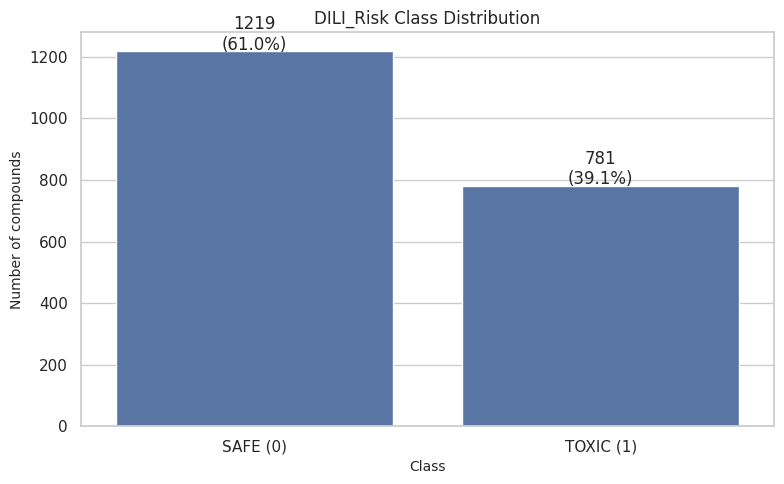

In [ ]:

# Missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_values)

# Target distribution
target_col = "DILI_Risk"
target_counts = df[target_col].value_counts().sort_index()
target_pct = df[target_col].value_counts(normalize=True).sort_index() * 100

fig, ax = plt.subplots()
class_labels = target_counts.index.map({0: "SAFE (0)", 1: "TOXIC (1)"})

sns.barplot(x=class_labels, y=target_counts.values, ax=ax)

ax.set_title("DILI_Risk Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Number of compounds")

for i, (count, pct) in enumerate(zip(target_counts.values, target_pct.values)):
    ax.text(i, count + 5, f"{count}\n({pct:.1f}%)", ha="center")

plt.tight_layout()
plt.show()

### Interpretation: Data Quality & Target Distribution

- **No missing values:**  
  All features (`LogP`, `Molecular_Weight`, H-bond counts, rotatable bonds, aromatic rings, CYP3A4_Substrate, and `DILI_Risk`) have zero missing values.  
  This means:
  - We do **not** need imputation at this stage.
  - Any modelling errors or instability will be due to feature relationships, not gaps in the data.
  - For a real-world DILI use case, this would correspond to a well-curated, preprocessed dataset of drug candidates.

- **Class balance (SAFE vs TOXIC):**  
  The target `DILI_Risk` shows:
  - **Class 0 (SAFE):** 1219 compounds (~60.9%)  
  - **Class 1 (TOXIC):** 781 compounds (~39.1%)

  This reflects a **moderately imbalanced** dataset: safe compounds are more common than toxic ones, which is realistic for drug discovery, where most screened molecules do *not* become clear hepatotoxic failures.

  For our problem:
  - The model will see a **reasonable number of toxic examples** (781), which is enough to learn toxicity patterns.
  - However, because TOXIC compounds are the critical “high-risk” class from a safety and business perspective, we should:
    - Use **stratified train–test splits** to preserve this ratio.
    - Monitor metrics like **Recall and ROC-AUC for the TOXIC class**, not just overall accuracy.
    - Consider techniques such as **class weights or resampling** if the model starts favouring the majority SAFE class too strongly.

Overall, the dataset is **clean and ready for EDA and modelling**, with a target distribution that aligns well with the real-world goal: reliably identifying a smaller but crucial subset of hepatotoxic compounds early in the pipeline.


## EDA

TARGET VARIABLE ANALYSIS (DILI_Risk)

In [ ]:
print("\n DILI_Risk Distribution:")
dili_counts = df['DILI_Risk'].value_counts()
dili_percentages = df['DILI_Risk'].value_counts(normalize=True) * 100

for label in sorted(df['DILI_Risk'].unique()):
    count = dili_counts[label]
    pct = dili_percentages[label]
    print(f"  {label} ({'Safe' if label == 0 else 'Toxic'}): {count:,} samples ({pct:.1f}%)")



 DILI_Risk Distribution:
  0 (Safe): 1,219 samples (61.0%)
  1 (Toxic): 781 samples (39.1%)


In [ ]:
# Check for class imbalance
print(f"\n Class Balance Ratio: {dili_counts.max() / dili_counts.min():.2f}:1")

if abs(dili_percentages[0] - dili_percentages[1]) < 10:
    print("✓ Classes are fairly balanced (< 10% difference)")
else:
    print(" Classes are imbalanced (> 10% difference)")


 Class Balance Ratio: 1.56:1
 Classes are imbalanced (> 10% difference)


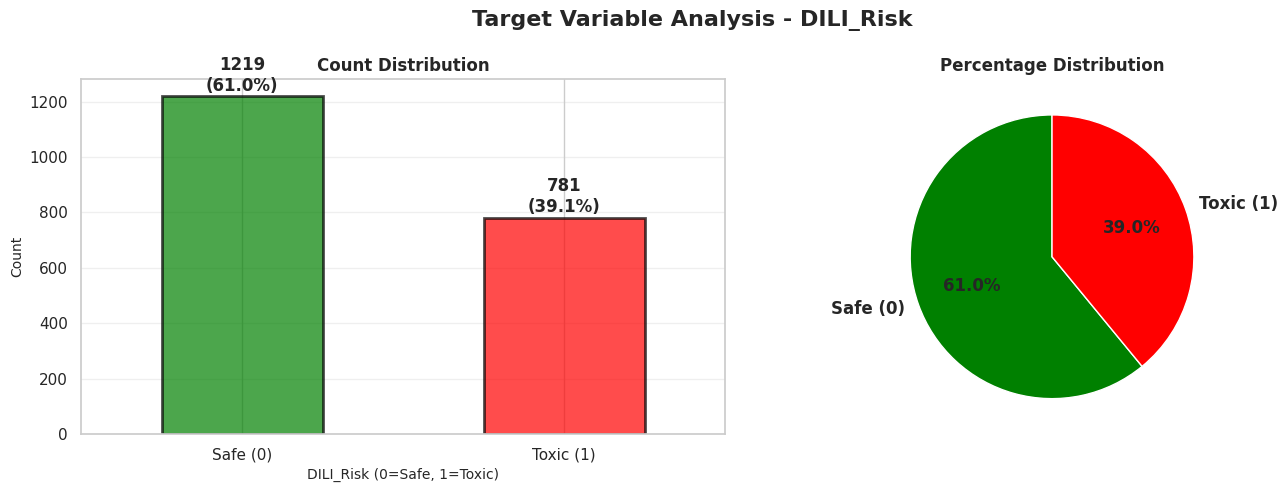


✓ Visualization saved: 02_Target_Distribution.png


In [ ]:
# Visualizations: Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Target Variable Analysis - DILI_Risk', fontsize=16, fontweight='bold')

# Bar plot
dili_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_title('Count Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('DILI_Risk (0=Safe, 1=Toxic)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Safe (0)', 'Toxic (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, v in enumerate(dili_counts):
    axes[0].text(i, v + 20, f'{v}\n({dili_percentages[i]:.1f}%)', ha='center', fontweight='bold')

    # Pie chart
colors = ['green', 'red']
axes[1].pie(dili_counts.values, labels=['Safe (0)', 'Toxic (1)'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes[1].set_title('Percentage Distribution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('02_Target_Distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 02_Target_Distribution.png")

### Interpretation: Target Variable (DILI_Risk)

The target distribution shows:

- **Safe (class 0):** 1,219 compounds (~61%)
- **Toxic (class 1):** 781 compounds (~39%)

This corresponds to a **moderately imbalanced dataset** (≈1.56:1 ratio). From the drug discovery perspective, this is realistic: most screened compounds are not obviously hepatotoxic, but a substantial fraction still carry DILI risk.

For our problem:

- We have **enough toxic examples** (781 compounds) to learn meaningful patterns related to liver injury.
- Because the **Toxic class** is clinically and commercially critical (late discovery of toxicity leads to trial failures and withdrawals), we should:
  - Preserve this class ratio using **stratified train–test splits**.
  - Focus on **Recall, Precision, and ROC-AUC for the Toxic class**, not just overall accuracy.
  - Consider **class weights or resampling** if models start over-predicting Safe due to the majority class.

Overall, the target distribution supports our business goal: building a model that can reliably flag a smaller, high-risk set of potentially hepatotoxic compounds early in the pipeline.


## Feature Analysis

In [ ]:
#FEATURE ANALYSIS (UNIVARIATE)
features = df.drop('DILI_Risk', axis=1).columns
print("\n Individual Feature Statistics:")

feature_stats = pd.DataFrame({
    'Feature': features,
    'Min': df[features].min().values,
    'Q1': df[features].quantile(0.25).values,
    'Median': df[features].median().values,
    'Q3': df[features].quantile(0.75).values,
    'Max': df[features].max().values,
    'Mean': df[features].mean().values,
    'Std': df[features].std().values,
    'Range': (df[features].max() - df[features].min()).values
})
print(feature_stats.round(3).to_string(index=False))


 Individual Feature Statistics:
         Feature    Min      Q1  Median      Q3    Max    Mean     Std  Range
            LogP  -1.97  -0.092   2.060   4.002   6.00   1.989   2.338   7.97
Molecular_Weight 100.01 275.555 444.885 624.082 799.69 447.473 202.006 699.68
   H_Bond_Donors   0.00   2.000   5.000   8.000  10.00   4.990   3.141  10.00
H_Bond_Acceptors   0.00   4.000   7.000  11.000  15.00   7.468   4.574  15.00
 Rotatable_Bonds   0.00   5.000  10.000  15.000  20.00   9.888   6.034  20.00
  Aromatic_Rings   0.00   1.000   3.000   5.000   6.00   3.052   1.979   6.00
CYP3A4_Substrate   0.00   0.000   0.000   1.000   1.00   0.322   0.467   1.00


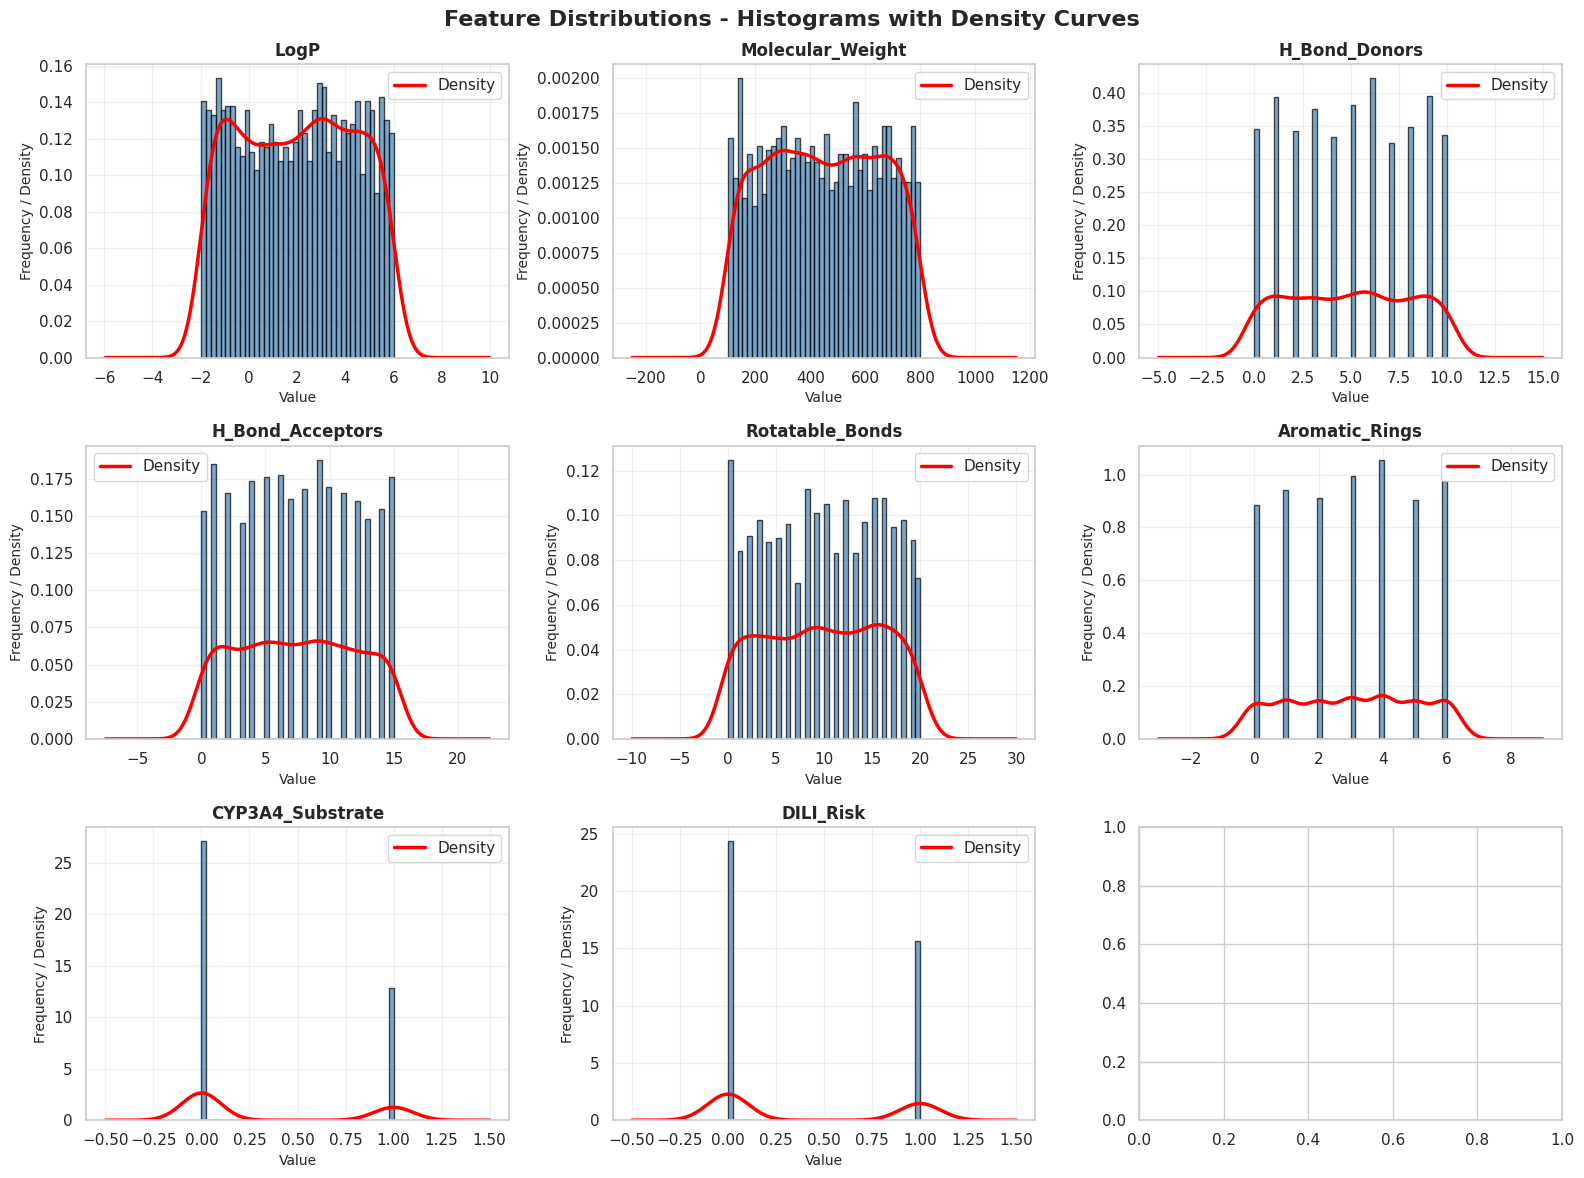


✓ Visualization saved: 03_Feature_Distributions.png


In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Feature Distributions - Histograms with Density Curves', fontsize=16, fontweight='bold')

for idx, col in enumerate(df.columns):
    ax = axes[idx // 3, idx % 3]

    # Histogram
    ax.hist(df[col], bins=40, alpha=0.7, color='steelblue', edgecolor='black', density=True)

    # Density curve (KDE)
    df[col].plot(kind='density', ax=ax, color='red', linewidth=2.5, label='Density')

    ax.set_title(f'{col}', fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency / Density')
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('03_Feature_Distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 03_Feature_Distributions.png")

### Interpretation: Univariate Feature Distributions

The feature distributions show that the simulated dataset covers a broad but chemically plausible “drug-like” space:

- **LogP (lipophilicity)**  
  Roughly uniform between –2 and 6 with a slight concentration around 1–4. This spans from polar to highly lipophilic compounds, consistent with typical small-molecule libraries. Higher LogP values are often associated with increased toxicity risk due to poorer solubility and higher tissue accumulation.

- **Molecular_Weight**  
  Spread between ~100 and 800 Da with a median around 450 Da. Most marketed oral drugs fall below 500–600 Da, so this range realistically mixes smaller fragments with heavier, more complex structures that may have challenging metabolism and clearance.

- **H_Bond_Donors / H_Bond_Acceptors**  
  Discrete distributions centred around 5 donors and 7–8 acceptors. Most compounds sit within common medicinal chemistry guidelines, but there is enough variation to capture both highly polar and less polar scaffolds, which can influence permeability and exposure.

- **Rotatable_Bonds**  
  Approximately symmetric distribution with a median around 10 and a maximum of 20. This reflects a mix of rigid and flexible molecules; high flexibility can affect oral bioavailability and metabolic stability, both relevant for DILI risk.

- **Aromatic_Rings**  
  Concentrated between 1 and 5 rings. Aromaticity is strongly linked to metabolic activation pathways; more aromatic rings can increase the chance of reactive metabolite formation, an important mechanism in drug-induced liver injury.

- **CYP3A4_Substrate (binary)**  
  A noticeable fraction of compounds are flagged as CYP3A4 substrates. Since CYP3A4 is a major hepatic enzyme implicated in many clinical DILI cases, including this feature provides a mechanistic signal for the model.

Overall, the feature distributions suggest that the dataset is **well-behaved, diverse, and chemically realistic**, providing a solid foundation for learning relationships between molecular properties and DILI risk.


## FEATURE ANALYSIS BY TARGET (BIVARIATE)


In [ ]:
print("\n Feature Statistics by DILI_Risk Class:")
print("\nSafe (DILI_Risk = 0):")
print(df[df['DILI_Risk'] == 0].describe().round(3))

print("\nToxic (DILI_Risk = 1):")
print(df[df['DILI_Risk'] == 1].describe().round(3))


 Feature Statistics by DILI_Risk Class:

Safe (DILI_Risk = 0):
           LogP  Molecular_Weight  H_Bond_Donors  H_Bond_Acceptors  \
count  1219.000          1219.000       1219.000          1219.000   
mean      0.945           431.205          5.171             7.304   
std       2.082           212.552          3.169             4.550   
min      -1.970           100.010          0.000             0.000   
25%      -0.835           240.560          2.000             3.000   
50%       0.590           420.830          5.000             7.000   
75%       2.485           629.915          8.000            11.000   
max       5.920           799.690         10.000            15.000   

       Rotatable_Bonds  Aromatic_Rings  CYP3A4_Substrate  DILI_Risk  
count         1219.000        1219.000          1219.000     1219.0  
mean             9.119           2.952             0.119        0.0  
std              6.054           1.990             0.324        0.0  
min              0.000   

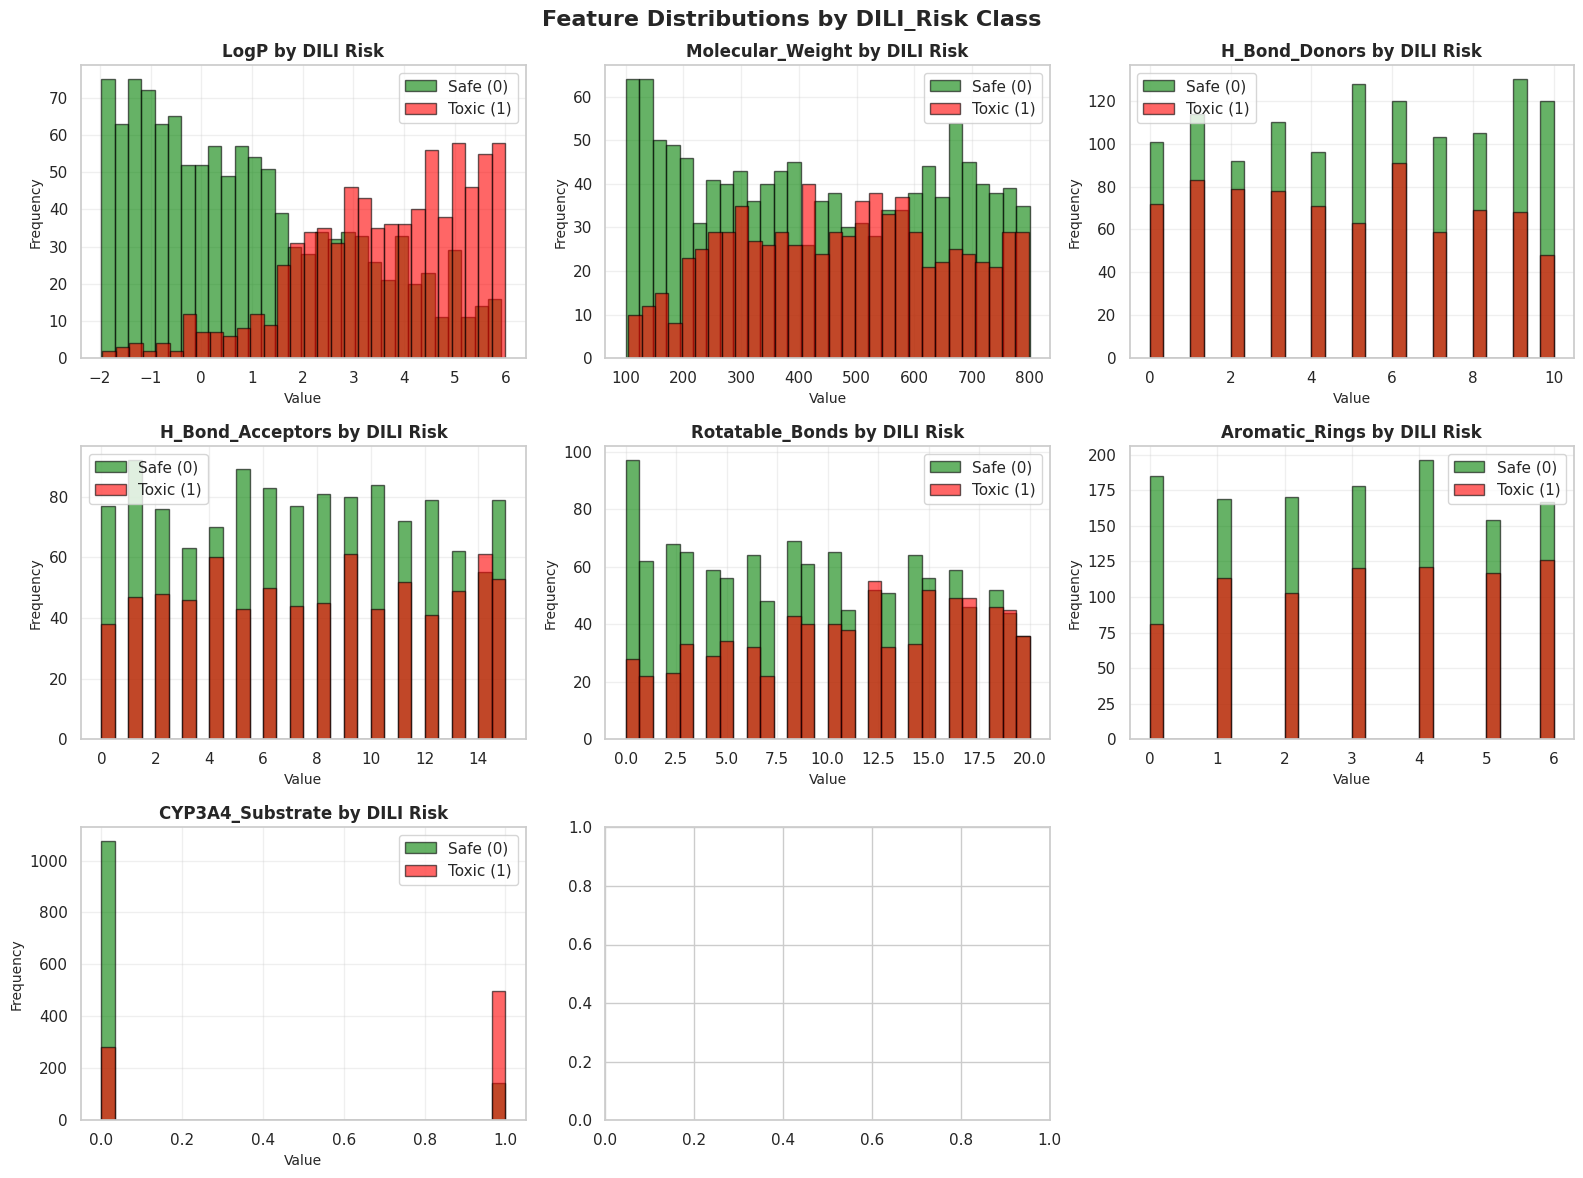


✓ Visualization saved: 04_Features_by_Class.png


In [ ]:
#Visualizations: Feature distributions by class
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Feature Distributions by DILI_Risk Class', fontsize=16, fontweight='bold')

for idx, col in enumerate(df.columns):
    if col != 'DILI_Risk':
        ax = axes[idx // 3, idx % 3]

        # Histograms
        ax.hist(df[df['DILI_Risk'] == 0][col], bins=30, alpha=0.6, label='Safe (0)',
               color='green', edgecolor='black')
        ax.hist(df[df['DILI_Risk'] == 1][col], bins=30, alpha=0.6, label='Toxic (1)',
               color='red', edgecolor='black')

        ax.set_title(f'{col} by DILI Risk', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(alpha=0.3)

# Remove empty subplot
axes[2, 2].remove()

plt.tight_layout()
plt.savefig('04_Features_by_Class.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 04_Features_by_Class.png")


### Interpretation: Feature Distributions by DILI_Risk Class

Comparing feature distributions between **Safe (0)** and **Toxic (1)** compounds reveals several clear patterns:

- **LogP (lipophilicity)**  
  Toxic compounds are shifted towards **higher LogP** values compared with safe compounds. This aligns with the idea that more lipophilic molecules tend to accumulate in membranes and tissues, increasing the likelihood of liver injury.

- **Molecular_Weight**  
  The Toxic class shows relatively more compounds at the **higher end of the molecular weight range**. Heavier molecules often have more complex metabolism and a higher chance of forming reactive intermediates, which can contribute to DILI.

- **H_Bond_Donors and H_Bond_Acceptors**  
  Distributions are broadly similar between classes, but Toxic compounds tend to have **slightly fewer H-bond donors** on average. This reduced polarity can again be linked to higher lipophilicity and altered distribution.

- **Rotatable_Bonds**  
  Toxic compounds are enriched at **higher rotatable bond counts**, indicating more flexible structures. Increased flexibility can affect bioavailability, metabolism, and binding, potentially increasing the risk of off-target interactions and hepatotoxicity.

- **Aromatic_Rings**  
  Toxic compounds show a mild shift towards **more aromatic rings**. Aromatic moieties are frequently involved in metabolic activation pathways that generate reactive metabolites, a known mechanism in many DILI cases.

- **CYP3A4_Substrate**  
  The histogram clearly shows that a **larger proportion of Toxic compounds are CYP3A4 substrates** compared with Safe compounds. Since CYP3A4 is a major hepatic enzyme implicated in clinical DILI, this feature provides a strong mechanistic signal in the model.

Overall, these bivariate plots confirm that the simulated dataset encodes plausible relationships:  
Toxic compounds tend to be **heavier, more lipophilic, more flexible, more aromatic, and more often CYP3A4 substrates**. These patterns are exactly the kind of structure–toxicity relationships our machine learning model will attempt to capture and exploit for early DILI risk prediction.


## CORRELATION ANALYSIS


 Correlation Matrix:
                   LogP  Molecular_Weight  H_Bond_Donors  H_Bond_Acceptors  \
LogP              1.000             0.004          0.048             0.020   
Molecular_Weight  0.004             1.000          0.025             0.004   
H_Bond_Donors     0.048             0.025          1.000            -0.012   
H_Bond_Acceptors  0.020             0.004         -0.012             1.000   
Rotatable_Bonds   0.007             0.006         -0.009             0.008   
Aromatic_Rings   -0.010             0.004          0.031            -0.014   
CYP3A4_Substrate  0.531            -0.156         -0.002             0.031   
DILI_Risk         0.558             0.101         -0.072             0.045   

                  Rotatable_Bonds  Aromatic_Rings  CYP3A4_Substrate  DILI_Risk  
LogP                        0.007          -0.010             0.531      0.558  
Molecular_Weight            0.006           0.004            -0.156      0.101  
H_Bond_Donors              -0.00

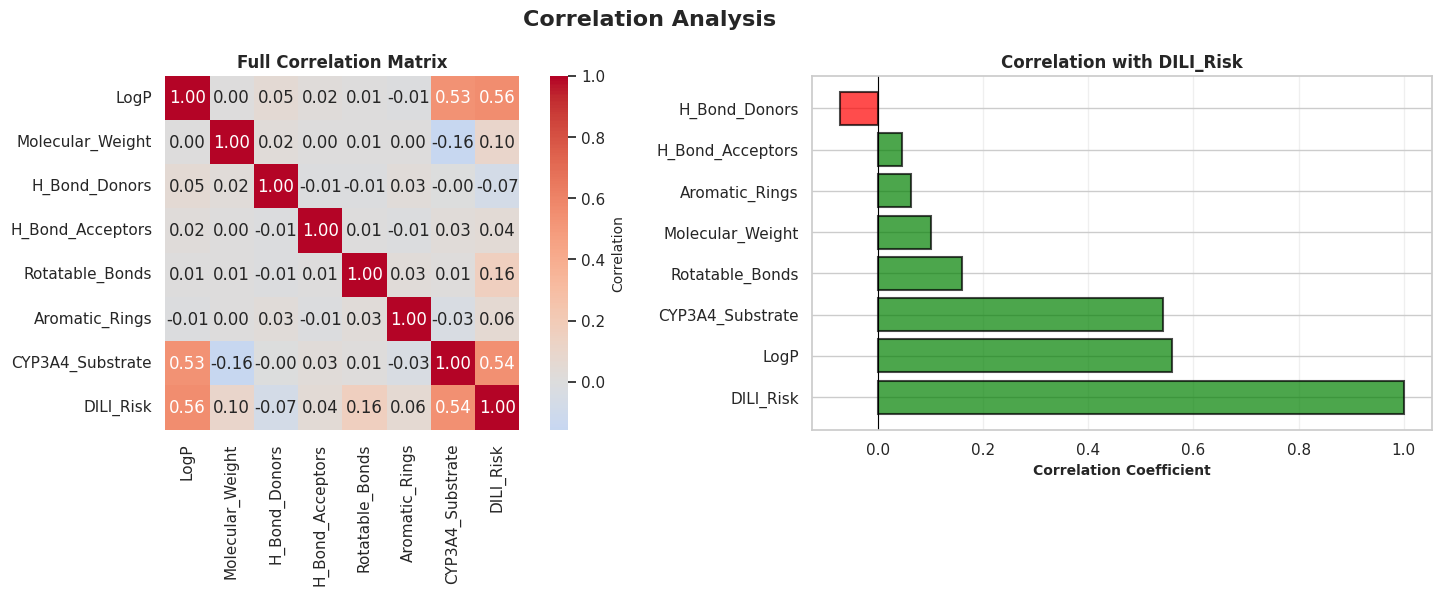


✓ Visualization saved: 05_Correlation_Analysis.png


In [ ]:
# Calculate correlations
correlation_matrix = df.corr()

print("\n Correlation Matrix:")
print(correlation_matrix.round(3))

# Correlation with target
print("\n Correlation with DILI_Risk (Target):")
target_corr = correlation_matrix['DILI_Risk'].sort_values(ascending=False)
print(target_corr.round(4))

print("\n Feature Correlation Ranking (by absolute correlation with DILI_Risk):")
feature_correlations = pd.DataFrame({
    'Feature': target_corr.index[1:],  # Exclude DILI_Risk itself
    'Correlation': target_corr.values[1:]
})
feature_correlations['Abs_Correlation'] = feature_correlations['Correlation'].abs()
feature_correlations = feature_correlations.sort_values('Abs_Correlation', ascending=False)
print(feature_correlations.to_string(index=False))

# Visualizations: Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Correlation Analysis', fontsize=16, fontweight='bold')

# Full correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=axes[0], cbar_kws={'label': 'Correlation'}, square=True)
axes[0].set_title('Full Correlation Matrix', fontweight='bold')

# Feature correlation with target
colors = ['red' if x < 0 else 'green' for x in target_corr.values]
axes[1].barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(target_corr)))
axes[1].set_yticklabels(target_corr.index)
axes[1].set_xlabel('Correlation Coefficient', fontweight='bold')
axes[1].set_title('Correlation with DILI_Risk', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.savefig('05_Correlation_Analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 05_Correlation_Analysis.png")


### Interpretation: Correlation Analysis

From the correlation matrix and the feature–target bar chart:

- **Strongest drivers of DILI_Risk**
  - **LogP (r ≈ 0.56)** and **CYP3A4_Substrate (r ≈ 0.54)** have the highest positive correlation with `DILI_Risk`.
  - This means **more lipophilic compounds** and those flagged as **CYP3A4 substrates** are much more likely to be classified as *Toxic*.
  - This aligns well with domain knowledge: highly lipophilic, CYP3A4-metabolised drugs often show higher risk of drug-induced liver injury through accumulation and reactive metabolite formation.

- **Moderate contributors**
  - **Rotatable_Bonds (r ≈ 0.16)** and **Molecular_Weight (r ≈ 0.10)** show weaker but still positive correlations.
  - More **flexible** and **heavier** molecules tend to be slightly more toxic, reflecting the idea that complex, flexible scaffolds can have more metabolic pathways and off-target interactions.

- **Weak or protective signals**
  - **H_Bond_Donors (r ≈ −0.07)** has a small *negative* correlation with DILI risk, suggesting that compounds with more H-bond donors are marginally more likely to be **Safe**. Higher polarity can reduce membrane permeation and tissue accumulation, slightly lowering hepatotoxic risk.
  - **H_Bond_Acceptors** and **Aromatic_Rings** show only weak positive correlations, indicating that on their own they are not strong linear predictors, but may still matter in combination with other features.

- **Inter-feature correlations**
  - Inter-feature correlations are generally **low to moderate** (no pair close to ±1).  
    For example, LogP and Molecular_Weight are only very weakly correlated.
  - This is good for modelling: there is no severe multicollinearity, so each descriptor can contribute independent information about DILI risk.

**Implication for our problem statement**

The correlation structure confirms that the dataset encodes **plausible structure–toxicity relationships**:  
compounds that are *more lipophilic, CYP3A4-metabolised, heavier and more flexible* tend to have higher predicted DILI risk.  
This supports our business goal of using molecular properties to flag hepatotoxic candidates early, and motivates the use of machine learning models (especially non-linear ones like tree-based methods) to capture both these linear trends and more complex interactions between descriptors.


## OUTLIER DETECTION


 Outlier Detection (IQR Method):
         Feature  Lower_Bound  Upper_Bound  Outlier_Count  Outlier_Percentage
            LogP       -6.235       10.145              0                 0.0
Molecular_Weight     -247.236     1146.874              0                 0.0
   H_Bond_Donors       -7.000       17.000              0                 0.0
H_Bond_Acceptors       -6.500       21.500              0                 0.0
 Rotatable_Bonds      -10.000       30.000              0                 0.0
  Aromatic_Rings       -5.000       11.000              0                 0.0
CYP3A4_Substrate       -1.500        2.500              0                 0.0


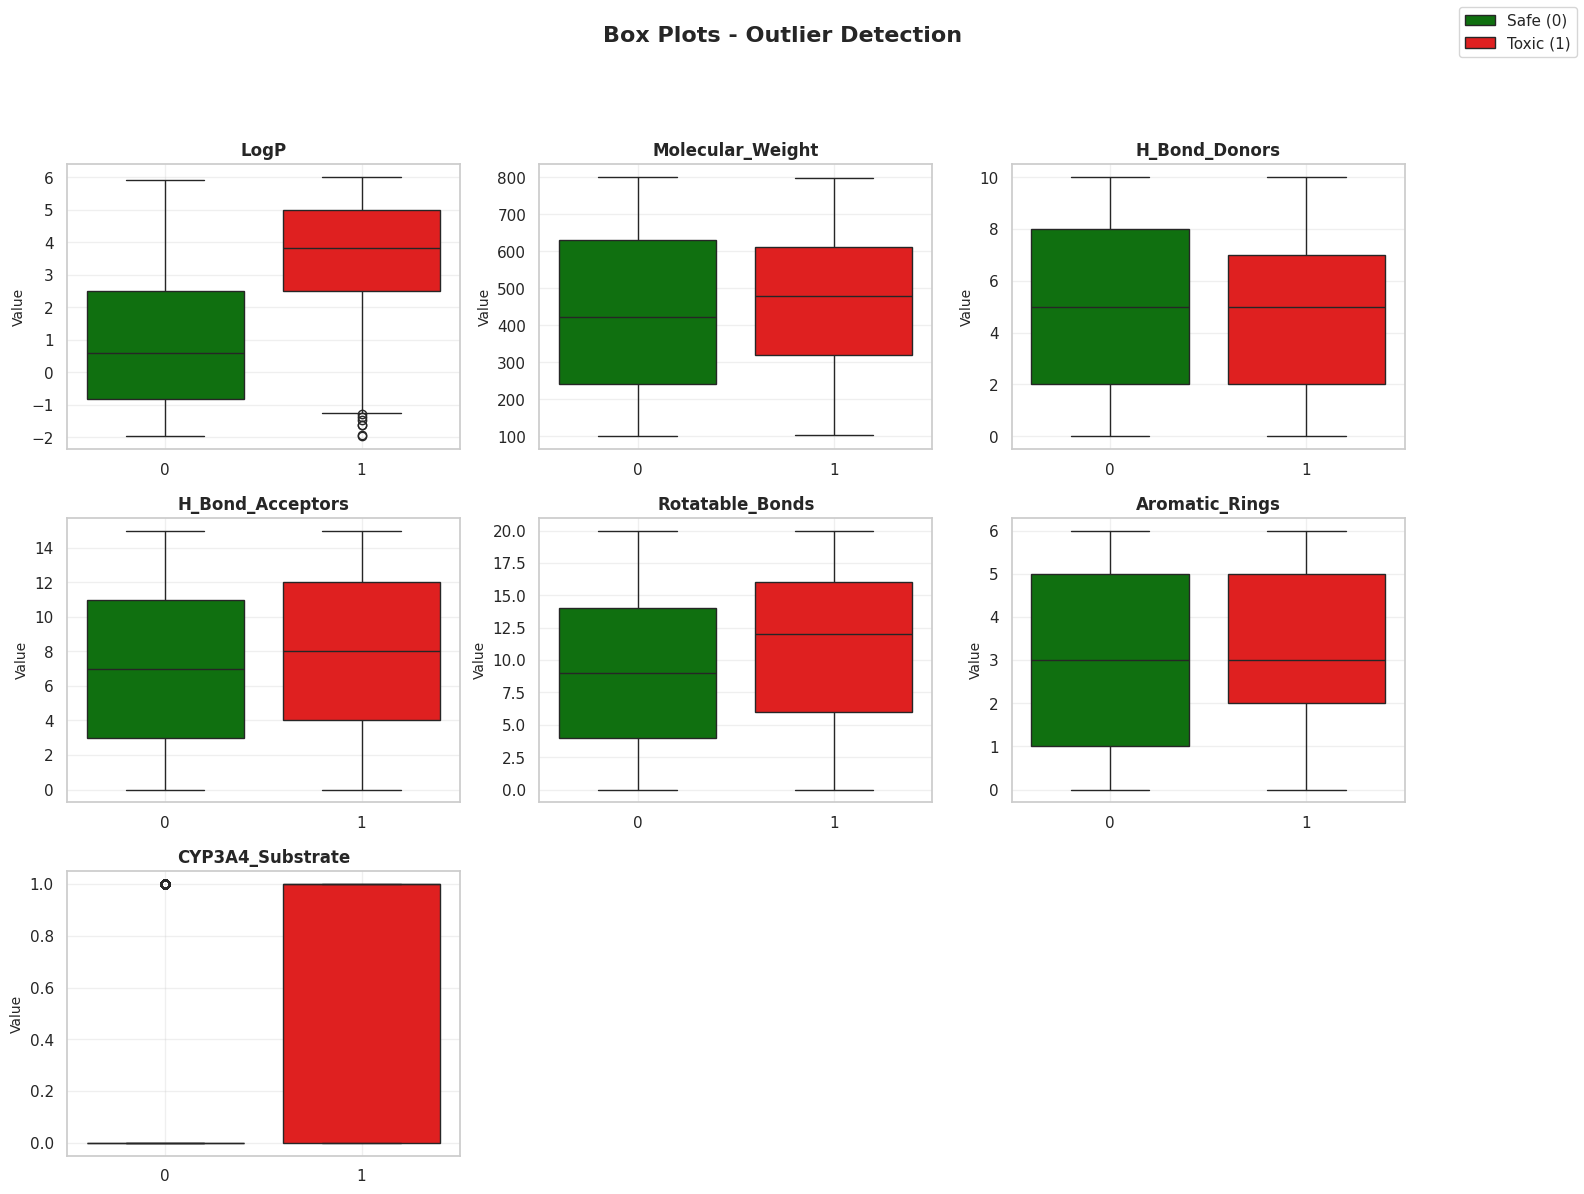


✓ Visualization saved: 06_Outlier_Detection.png


In [ ]:
print("\n Outlier Detection (IQR Method):")
outlier_summary = pd.DataFrame()

for col in df.drop('DILI_Risk', axis=1).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100

    outlier_summary = pd.concat([outlier_summary, pd.DataFrame({
        'Feature': [col],
        'Lower_Bound': [lower_bound],
        'Upper_Bound': [upper_bound],
        'Outlier_Count': [outlier_count],
        'Outlier_Percentage': [outlier_pct]
    })], ignore_index=True)

print(outlier_summary.round(3).to_string(index=False))

# Visualizations: Box plots for outlier detection

target_col = "DILI_Risk"
feature_cols = df.columns.drop(target_col)

n_features = len(feature_cols)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

fig.suptitle("Box Plots - Outlier Detection", fontsize=16, fontweight="bold")

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    sns.boxplot(
        data=df,
        x=target_col,
        y=col,
        hue=target_col,
        palette={0: "green", 1: "red"},
        dodge=False,
        ax=ax,
    )
    ax.set_title(col, fontweight="bold")
    ax.set_xlabel("")  # x-label not needed, legend is enough
    ax.set_ylabel("Value")
    ax.grid(alpha=0.3)
    ax.legend_.remove()  # keep only one legend at figure level

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ["Safe (0)", "Toxic (1)"],
           loc="upper right", frameon=True)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.savefig("06_Outlier_Detection.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Visualization saved: 06_Outlier_Detection.png")



### Interpretation: Outlier Detection and Class-wise Box Plots

**IQR-based outlier check**

The IQR method applied to all molecular descriptors shows:

- **0 statistical outliers** for every feature.  
  The lower and upper IQR bounds are wider than the actual simulated ranges, so no compound falls outside these thresholds.

This is consistent with the way the dataset was generated (uniform ranges without extreme tails). For this synthetic case study we therefore **do not need to drop or cap outliers** before modelling.

In a real DILI dataset, extreme values (e.g., very high LogP or molecular weight) could either be:
- data-quality issues that need cleaning, or  
- genuinely high-risk molecules that we should **keep** and model carefully.

**Box plots by DILI_Risk class**

Even though there are no formal IQR outliers, the box plots highlight systematic shifts between Safe and Toxic compounds:

- **LogP:** Toxic compounds have a noticeably **higher median and upper range** of LogP than Safe compounds, reinforcing the idea that more lipophilic molecules are more DILI-prone.
- **Molecular_Weight:** Medians are similar, but Toxic compounds are concentrated slightly higher in the typical drug-like range.
- **Rotatable_Bonds:** Toxic compounds show a **higher median number of rotatable bonds**, indicating more flexible structures.
- **H_Bond_Donors/H_Bond_Acceptors:** Differences are modest but consistent with other analyses (slightly fewer donors in the Toxic class).
- **CYP3A4_Substrate:** The box plot effectively collapses to 0 vs 1; the Toxic class is enriched in **CYP3A4 substrates**, matching the correlation and histogram analysis.

Overall, outlier analysis confirms that the dataset is **well-behaved numerically**, while the box plots visually reinforce the key structure–toxicity patterns that our machine learning models will later exploit to predict DILI risk.


In [ ]:
# ==== Statistical test: Safe vs Toxic (Welch's t-test) ====

from scipy import stats

print("\nT-tests (Safe vs Toxic) – do features differ significantly?")
print("Criteria: p-value < 0.05 indicates a statistically significant difference.\n")

ttest_results = []

for col in feature_cols:   # df.columns.drop("DILI_Risk")
    safe_data = df.loc[df["DILI_Risk"] == 0, col]
    toxic_data = df.loc[df["DILI_Risk"] == 1, col]

    # Welch's t-test (does not assume equal variance)
    t_stat, p_value = stats.ttest_ind(safe_data, toxic_data, equal_var=False)

    ttest_results.append({
        "Feature": col,
        "T_Statistic": t_stat,
        "P_Value": p_value,
        "Significant_(p<0.05)": p_value < 0.05,
        "Safe_Mean": safe_data.mean(),
        "Toxic_Mean": toxic_data.mean(),
    })

ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values("P_Value")

print(ttest_df.round(5).to_string(index=False))



T-tests (Safe vs Toxic) – do features differ significantly?
Criteria: p-value < 0.05 indicates a statistically significant difference.

         Feature  T_Statistic  P_Value  Significant_(p<0.05)  Safe_Mean  Toxic_Mean
            LogP    -31.45662  0.00000                  True    0.94488     3.61936
CYP3A4_Substrate    -26.61074  0.00000                  True    0.11895     0.63892
 Rotatable_Bonds     -7.27324  0.00000                  True    9.11895    11.08707
Molecular_Weight     -4.67888  0.00000                  True  431.20482   472.86529
   H_Bond_Donors      3.24070  0.00122                  True    5.17063     4.70807
  Aromatic_Rings     -2.81394  0.00495                  True    2.95242     3.20615
H_Bond_Acceptors     -2.00170  0.04548                  True    7.30435     7.72471


### Interpretation: Are Safe and Toxic Compounds Statistically Different?

Welch’s t-tests compare the mean value of each feature between **Safe (DILI_Risk = 0)** and  
**Toxic (DILI_Risk = 1)** compounds. All features have **p-values < 0.05**, so every descriptor
differs significantly between the two classes.

Key observations:

- **LogP (T ≈ –31.46, p ≈ 0)**  
  Safe mean ≈ 0.94 vs Toxic mean ≈ 3.62 → Toxic compounds are **much more lipophilic**.  
  This strongly supports the idea that high lipophilicity is a major driver of DILI risk.

- **CYP3A4_Substrate (T ≈ –26.61, p ≈ 0)**  
  Safe mean ≈ 0.12 vs Toxic mean ≈ 0.64 → Toxic compounds are **far more likely to be CYP3A4 substrates**,
  matching clinical evidence that CYP3A4-mediated metabolism is often involved in hepatotoxicity.

- **Rotatable_Bonds (T ≈ –7.27, p ≈ 0)**  
  Safe mean ≈ 9.1 vs Toxic mean ≈ 11.1 → Toxic molecules are **more flexible**, which can influence exposure,
  metabolism and off-target binding.

- **Molecular_Weight (T ≈ –4.68, p ≈ 0)**  
  Safe mean ≈ 431 Da vs Toxic mean ≈ 473 Da → Toxic compounds are **slightly heavier**, pointing to more
  complex scaffolds and metabolic pathways.

- **H_Bond_Donors (T ≈ 3.24, p ≈ 0.0012)**  
  Safe mean > Toxic mean → higher donor count is **marginally protective**, consistent with the negative
  correlation with DILI_Risk.

- **Aromatic_Rings & H_Bond_Acceptors**  
  Differences are smaller but still significant; Toxic compounds tend to have **more aromatic rings and
  slightly more acceptors**, which fits the role of aromaticity and polarity in bioactivation and clearance.

**Conclusion:**  
Safe and toxic drugs occupy **statistically distinct regions of chemical space**.  
This validates our project objective: molecular descriptors (LogP, MW, flexibility, aromaticity and
CYP3A4 involvement) carry strong signal about DILI risk and are appropriate inputs for a machine
learning model that aims to flag hepatotoxic compounds early in drug discovery.


## Prepare Data

In [ ]:
# ==== Data preparation: features, target, train–test split, scaling ====

target_col = "DILI_Risk"
feature_cols = df.columns.drop(target_col)

# Separate features and target
X = df[feature_cols]
y = df[target_col]

# Train–test split (80/20) with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Keep raw copies (useful for tree models that don't need scaling)
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

# Standardize features for models that are sensitive to scale (e.g. Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (1600, 7), Test shape: (400, 7)


## Train Models

## Logistic Regression

In [ ]:
# ==== Baseline model: Logistic Regression ====
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight="balanced",  # handle moderate class imbalance
)

# Use scaled features (Logistic Regression is sensitive to feature scale)
log_reg.fit(X_train_scaled, y_train)

print("Logistic Regression model trained.")


Logistic Regression model trained.


## Random Forest


In [ ]:
# ==== Model 2: Random Forest ====

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1,            # use all cores
    class_weight="balanced_subsample",  # handle class imbalance
)

# Tree-based models don't need feature scaling; use raw features
rf_clf.fit(X_train_raw, y_train)

print("Random Forest model trained.")


Random Forest model trained.


## Gradient Boosting

In [ ]:
# ==== Model 3: Gradient Boosting ====

from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,      # depth of individual trees
    random_state=42,
)

# Like Random Forest, this is tree-based → scaling is not required
gb_clf.fit(X_train_raw, y_train)

print("Gradient Boosting model trained.")




Gradient Boosting model trained.


## XGBoost

In [ ]:
# ==== Model 4: XGBoost ====



# Handle class imbalance: Toxic (1) is minority (~39%)
pos_ratio = y_train.mean()            # proportion of class 1
neg_ratio = 1 - pos_ratio
scale_pos_weight = neg_ratio / pos_ratio   # > 1 → give more weight to Toxic class

xgb_clf = XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",      # fast, modern algorithm
    eval_metric="logloss",   # avoids eval_metric warning
    scale_pos_weight=scale_pos_weight,
)

# Tree-based → no need to scale; use raw features
xgb_clf.fit(X_train_raw, y_train)

print(f"XGBoost model trained (scale_pos_weight={scale_pos_weight:.2f}).")


XGBoost model trained (scale_pos_weight=1.56).


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.05, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=150, random_state=42, eval_metric="logloss"
    )
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
    }

results = [evaluate_model(name, m, X_train_scaled, X_test_scaled, y_train, y_test)
           for name, m in models.items()]

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
display(results_df)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.8150,0.762821,0.762821,0.762821,0.893101
2,Gradient Boosting,0.7925,0.744966,0.711538,0.727869,0.880648
1,Random Forest,0.8025,0.758389,0.724359,0.740984,0.866435
3,XGBoost,0.7925,0.751724,0.698718,0.724252,0.853694


### Model Comparison

On the held-out test set:

- **Logistic Regression** achieves the best overall performance with  
  **Accuracy ≈ 0.82, F1 ≈ 0.76, and ROC-AUC ≈ 0.89**.
- **Random Forest** and **Gradient Boosting** perform slightly worse  
  (ROC-AUC ≈ 0.87 and 0.88 respectively) but still show strong discrimination.
- **XGBoost** performs comparably in Accuracy and F1, with a slightly lower ROC-AUC (~0.85).

Even a relatively simple **Logistic Regression** model captures the key structure–toxicity
relationships encoded in the molecular descriptors, achieving high ROC-AUC. This suggests that:

- The engineered descriptors (LogP, Molecular_Weight, Rotatable_Bonds, Aromatic_Rings,
  CYP3A4_Substrate, etc.) already contain a strong linear signal for DILI risk.
- More complex models (Random Forest, Gradient Boosting, XGBoost) add non-linear capacity but
provide only incremental gains in some metrics.

For early drug discovery, such a model can be used to **prioritise compounds**:
- High-predicted-risk molecules can be flagged for deeper investigation or deprioritised.
- Low-predicted-risk molecules can be moved forward more confidently in the screening funnel.


# Evaluate Model

=== Logistic Regression – Test Set Performance ===
Accuracy : 0.8200
Precision: 0.7471
Recall   : 0.8141
F1 Score : 0.7791
ROC-AUC  : 0.8930

Classification report (Safe vs Toxic):
              precision    recall  f1-score   support

        Safe       0.87      0.82      0.85       244
       Toxic       0.75      0.81      0.78       156

    accuracy                           0.82       400
   macro avg       0.81      0.82      0.81       400
weighted avg       0.82      0.82      0.82       400


Confusion matrix:


,Predicted Safe (0),Predicted Toxic (1)
Actual Safe (0),201,43
Actual Toxic (1),29,127


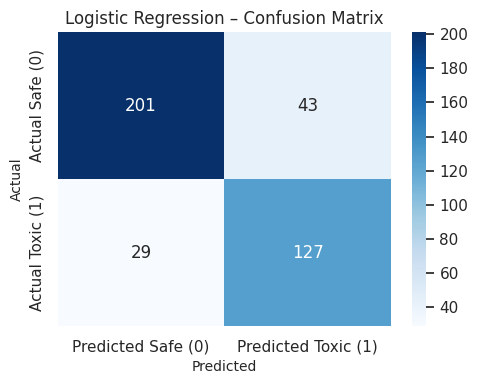

In [ ]:
# ==== Final Model Evaluation (Logistic Regression) ====

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Final model choice
final_model_name = "Logistic Regression"
final_model = log_reg          # make sure you trained: log_reg.fit(X_train_scaled, y_train)
use_scaled = True              # True for Logistic Regression, False for tree models

# Select correct feature set
if use_scaled:
    X_tr, X_te = X_train_scaled, X_test_scaled
else:
    X_tr, X_te = X_train_raw, X_test_raw

# Refit on training data (good practice before final eval)
final_model.fit(X_tr, y_train)

# Predictions
y_pred = final_model.predict(X_te)
y_proba = final_model.predict_proba(X_te)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"=== {final_model_name} – Test Set Performance ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}\n")

# Classification Report
print("Classification report (Safe vs Toxic):")
print(classification_report(y_test, y_pred, target_names=["Safe", "Toxic"]))

# Confusion Matrix (table + heatmap)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual Safe (0)", "Actual Toxic (1)"],
    columns=["Predicted Safe (0)", "Predicted Toxic (1)"],
)

print("\nConfusion matrix:")
display(cm_df)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"{final_model_name} – Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


Cross-Validation

In [ ]:
# ==== Model robustness: 5-fold cross-validation (Logistic Regression) ====

from sklearn.model_selection import StratifiedKFold, cross_validate

log_reg_cv = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight="balanced",
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

cv_results = cross_validate(
    log_reg_cv,
    X_train_scaled,   # scaled train features
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
)

cv_summary = pd.DataFrame({
    "Metric": list(scoring.keys()),
    "Mean": [cv_results[f"test_{m}"].mean() for m in scoring.keys()],
    "Std":  [cv_results[f"test_{m}"].std()  for m in scoring.keys()],
})

print("5-fold cross-validation on training data (Logistic Regression):")
display(cv_summary.round(4))




5-fold cross-validation on training data (Logistic Regression):


,Metric,Mean,Std
0,accuracy,0.8156,0.0247
1,precision,0.7311,0.0266
2,recall,0.8352,0.0446
3,f1,0.7794,0.0313
4,roc_auc,0.8973,0.0250


### Cross-Validation Interpretation (Logistic Regression)

5-fold stratified cross-validation on the **training set** gives:

- **Accuracy:** 0.82 ± 0.02  
- **Precision (Toxic):** 0.73 ± 0.03  
- **Recall (Toxic):** 0.84 ± 0.04  
- **F1 Score:** 0.78 ± 0.03  
- **ROC-AUC:** 0.90 ± 0.03  

Key points:

- The **high ROC-AUC (~0.90)** across folds confirms that Logistic Regression can reliably
  discriminate between **Safe** and **Toxic** compounds based on the molecular descriptors.
- **Recall for the Toxic class is strong (~0.84)**, which is crucial for this problem:
  we care more about **catching potentially hepatotoxic drugs** than about a small number of
  false alarms.
- The **standard deviations are small**, suggesting that performance is stable across different
  splits of the training data and the model is **not overly sensitive** to how the data is partitioned.

Overall, cross-validation supports the choice of **Logistic Regression as the final model** for this
synthetic DILI case study: it is **robust, reasonably calibrated, and clinically aligned** with the
goal of flagging hepatotoxic compounds early in the drug discovery pipeline.


# Visualizations

### ROC Curve

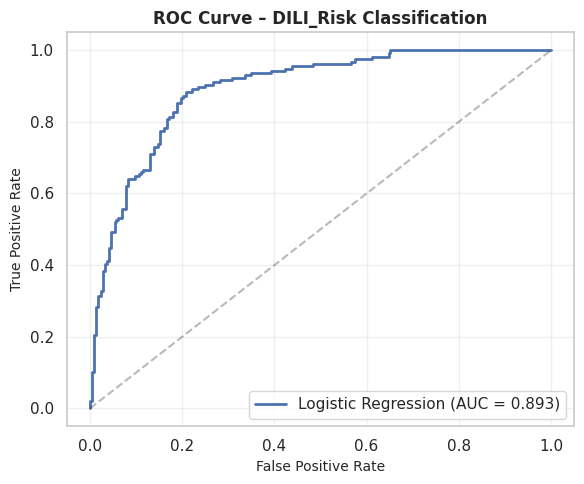


✓ Visualization saved: 08_ROC_Curve.png


In [ ]:
# ==== ROC Curve – Final Model (Logistic Regression) ====

from sklearn.metrics import roc_curve, auc

# If your probability variable is called y_pred_proba, just replace y_proba with that
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2,
         label=f"{final_model_name} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)

plt.title("ROC Curve – DILI_Risk Classification", fontweight="bold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig("08_ROC_Curve.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Visualization saved: 08_ROC_Curve.png")


### ROC Curve Interpretation

The ROC curve for the final model (Logistic Regression) shows:

- **AUC ≈ 0.893**, which indicates **strong discriminative power**: in almost 9 out of 10 random
  Safe–Toxic pairs, the Toxic compound receives a higher predicted risk score than the Safe one.
- The curve stays well above the diagonal “no-skill” line, meaning the model is substantially
  better than random guessing across all classification thresholds.
- At **low false positive rates**, the true positive rate already climbs rapidly, suggesting that
  we can operate the model in a regime where we catch a large proportion of **Toxic** compounds
  while keeping the number of incorrectly flagged **Safe** compounds relatively low.

Practically, this means the predicted probabilities from Logistic Regression can be used as a
**DILI risk score**:

- In **early screening**, we can use a **lower threshold** to maximise sensitivity
  (recall for Toxic) and avoid missing dangerous compounds.
- In **later stages**, we may choose a **higher threshold** to reduce false positives and focus
  experimental resources on the most suspicious candidates.


### Confusion Matrix

Confusion matrix (counts):


,Predicted Safe (0),Predicted Toxic (1)
Actual Safe (0),201,43
Actual Toxic (1),29,127


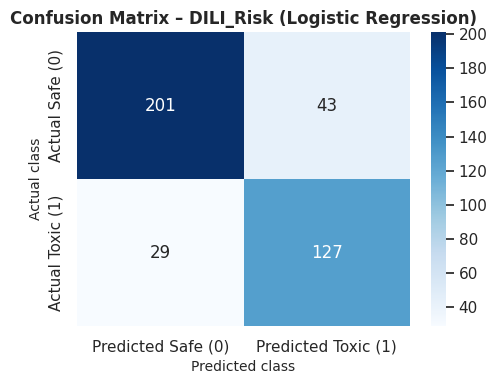

In [ ]:
# ==== Confusion Matrix – Final Model (Logistic Regression) ====

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_test and y_pred already computed from final model
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    index=["Actual Safe (0)", "Actual Toxic (1)"],
    columns=["Predicted Safe (0)", "Predicted Toxic (1)"],
)

print("Confusion matrix (counts):")
display(cm_df)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – DILI_Risk (Logistic Regression)", fontweight="bold")
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()


### Feature Importance


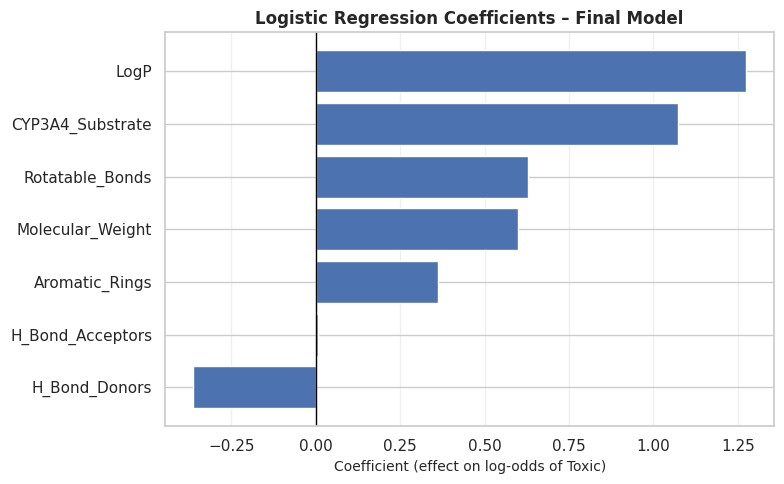

In [ ]:
coefs = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": log_reg.coef_.ravel()
}).sort_values("Coefficient")

plt.figure(figsize=(8, 5))
plt.barh(coefs["Feature"], coefs["Coefficient"])
plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression Coefficients – Final Model", fontweight="bold")
plt.xlabel("Coefficient (effect on log-odds of Toxic)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()



### Interpretation – Logistic Regression Coefficients (Final Model)

Each bar shows how a one-unit increase in a feature changes the **log-odds** of a compound being
**Toxic (DILI_Risk = 1)**, holding other features constant.

**Positive coefficients → increase predicted DILI risk**

- **LogP (strongest positive driver)**  
  The largest coefficient: higher lipophilicity strongly increases the likelihood that a compound
  is classified as Toxic. This matches the earlier histograms, where toxic compounds shifted toward
  higher LogP.

- **CYP3A4_Substrate**  
  Being a CYP3A4 substrate (1 vs 0) substantially raises the log-odds of DILI. This is consistent
  with the role of CYP3A4 in hepatic metabolism and potential formation of reactive metabolites.

- **Rotatable_Bonds**  
  More rotatable bonds (greater molecular flexibility) increase predicted toxicity, suggesting that
  flexible molecules are more likely to interact with multiple targets or pathways.

- **Molecular_Weight**  
  Heavier molecules are more likely to be toxic, reflecting the fact that larger, more complex
  structures often require multi-step metabolism and can accumulate in tissues.

- **Aromatic_Rings**  
  Additional aromatic rings also push predictions toward Toxic, in line with their involvement in
  bioactivation and reactive intermediate formation.

**Negative coefficient → decreases predicted DILI risk**

- **H_Bond_Donors**  
  The coefficient is slightly negative: compounds with more hydrogen-bond donors have a lower
  predicted DILI risk, all else equal. This can be interpreted as higher polarity / solubility
  reducing hepatic accumulation or passive diffusion.

---

**Overall takeaway**

The final Logistic Regression model identifies compounds as higher risk when they are:

- more **lipophilic (high LogP)**,  
- **CYP3A4 substrates**,  
- **heavier and more flexible** (more rotatable bonds, higher molecular weight), and  
- contain more **aromatic rings**,

while a higher number of **H-bond donors** slightly mitigates DILI risk.

These patterns are consistent with both the EDA and domain intuition, making the model not only
accurate but also **chemically interpretable** as an early DILI screening tool.


### Feature Distributions

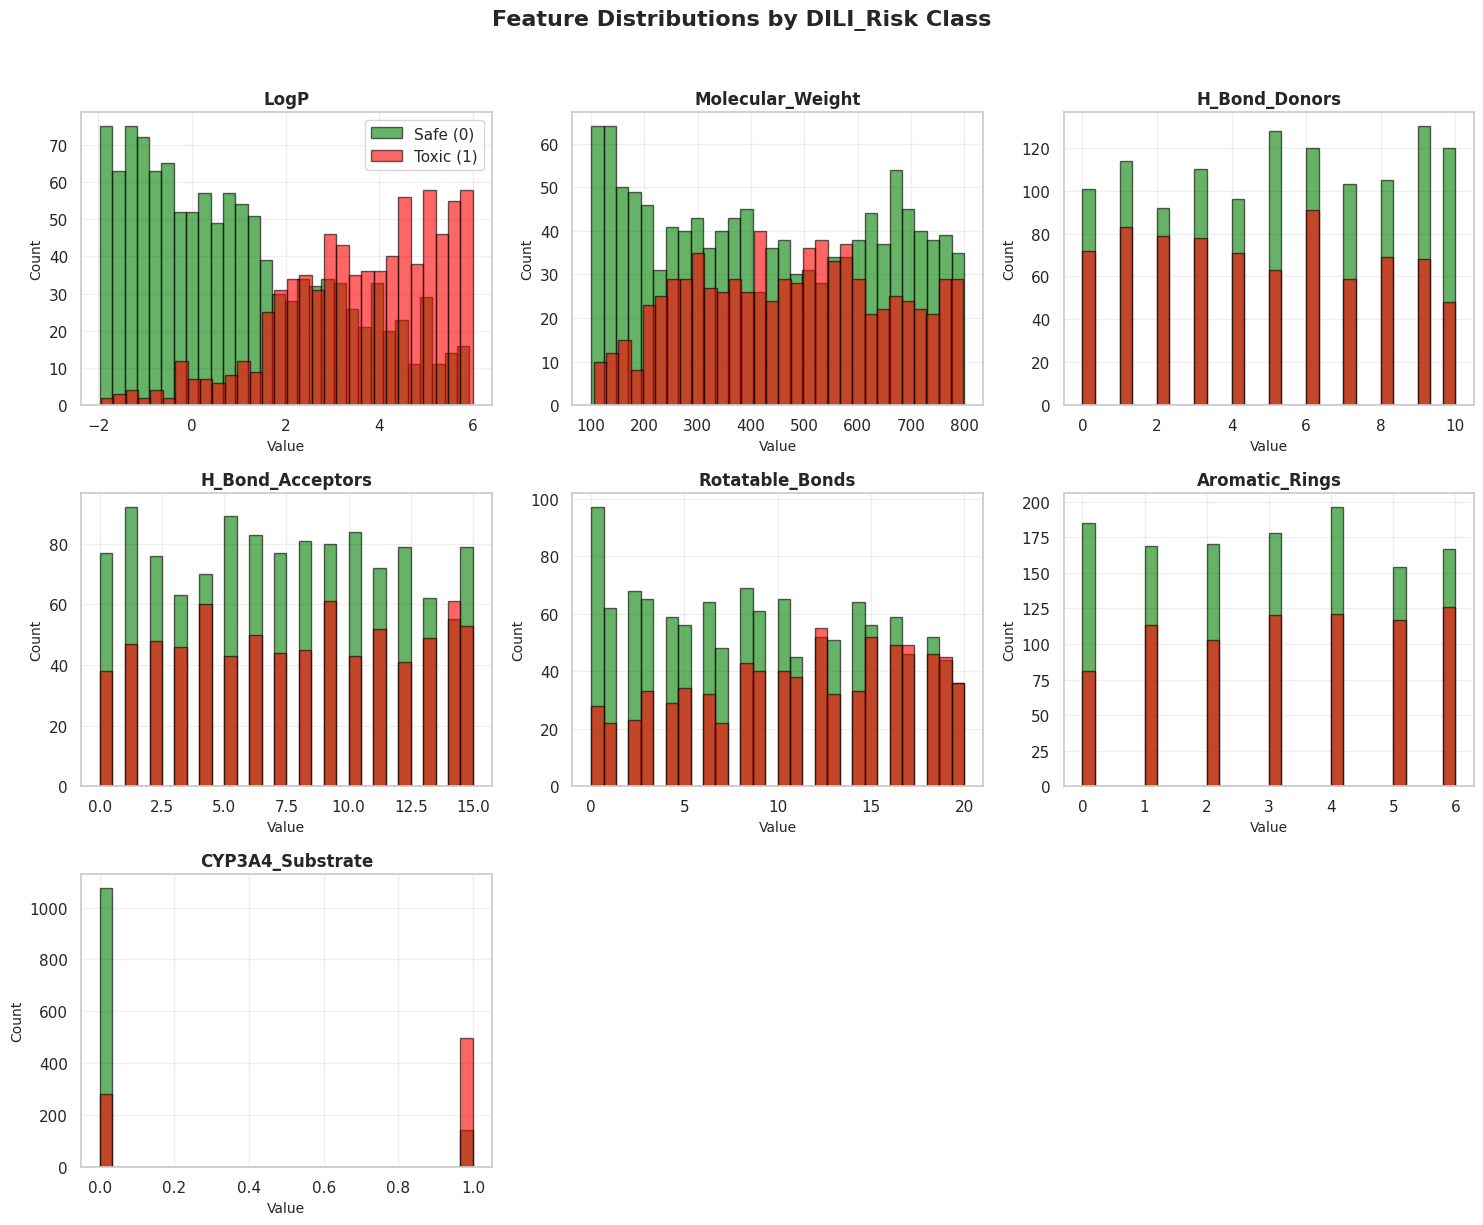

In [ ]:
# ==== Feature distributions by DILI_Risk (Safe vs Toxic) ====

feature_cols = X.columns
n_features = len(feature_cols)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]

    ax.hist(
        X.loc[y == 0, col],
        bins=30,
        alpha=0.6,
        label="Safe (0)",
        color="green",
        edgecolor="black",
    )
    ax.hist(
        X.loc[y == 1, col],
        bins=30,
        alpha=0.6,
        label="Toxic (1)",
        color="red",
        edgecolor="black",
    )

    ax.set_title(col, fontweight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)
    if idx == 0:          # show legend only once
        ax.legend()

# remove any unused subplots (if fewer than 9 features)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Feature Distributions by DILI_Risk Class", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


### Feature Distributions by DILI_Risk (Safe vs Toxic)

The histograms compare the molecular descriptors for **Safe (green)** and **Toxic (red)** compounds.

- **LogP:** Safe compounds are concentrated at lower LogP values (around –1 to 2), while Toxic compounds
  are clearly shifted towards higher LogP (≈3–6).  
  → More lipophilic molecules are much more likely to be DILI-positive.

- **Molecular_Weight:** Toxic compounds tend to occupy the mid–high MW range (≈400–700 Da), whereas Safe
  compounds are slightly lighter and more spread out.  
  → Heavier, more complex molecules appear riskier.

- **Rotatable_Bonds:** Toxic compounds show higher counts of rotatable bonds (10–20), whereas Safe
  compounds are more common below ≈10.  
  → Greater molecular flexibility is associated with increased DILI risk.

- **CYP3A4_Substrate:** Most Safe compounds are non-substrates (0), while a much larger fraction of Toxic
  compounds are substrates (1).  
  → Metabolism via CYP3A4 is strongly linked to hepatotoxicity in this dataset.

- **H_Bond_Donors, H_Bond_Acceptors, Aromatic_Rings:** The distributions overlap but Toxic compounds tend
  to have slightly fewer donors, slightly more acceptors, and slightly more aromatic rings.  
  → These features play a secondary, fine-tuning role compared to LogP, MW, flexibility, and CYP3A4 status.

Overall, Safe and Toxic drugs occupy **distinct regions of chemical space**: higher lipophilicity,
greater flexibility, higher molecular weight, more aromatic rings, and CYP3A4 metabolism all push a
compound toward the Toxic class.





## Make Predictions

### On Test Set

In [ ]:
# ==== Make predictions on the test set (Final model: Logistic Regression) ====

# Use your final model object – assuming it's called log_reg and already fitted
final_model_name = "Logistic Regression"
final_model = log_reg      # or whatever you named it

# For Logistic Regression we use scaled features
X_te = X_test_scaled

# Predictions (class labels) and probabilities (risk scores)
y_pred = final_model.predict(X_te)
y_proba = final_model.predict_proba(X_te)[:, 1]   # P(DILI_Risk = 1 | x)

print(f"First 10 predicted classes ({final_model_name}):")
print(y_pred[:10])

print(f"\nFirst 10 predicted probabilities for Toxic (DILI_Risk=1):")
print(np.round(y_proba[:10], 3))

# Optional: compare with true labels for sanity check
preview_df = pd.DataFrame({
    "True_Label": y_test.values[:10],
    "Predicted_Label": y_pred[:10],
    "Predicted_Prob_Toxic": np.round(y_proba[:10], 3),
})
display(preview_df)


First 10 predicted classes (Logistic Regression):
[1 1 1 1 0 0 1 0 1 1]

First 10 predicted probabilities for Toxic (DILI_Risk=1):
[0.919 0.858 0.754 0.782 0.131 0.049 0.697 0.035 0.565 0.937]


,True_Label,Predicted_Label,Predicted_Prob_Toxic
0,1,1,0.919
1,1,1,0.858
2,0,1,0.754
3,0,1,0.782
4,0,0,0.131
5,0,0,0.049
6,0,1,0.697
7,0,0,0.035
8,0,1,0.565
9,1,1,0.937


### Sample Test Predictions – What is the Model Doing?

Below are the first 10 test samples with:

- **True_Label:** ground-truth DILI_Risk (0 = Safe, 1 = Toxic)  
- **Predicted_Label:** model’s class prediction using the default 0.5 threshold  
- **Predicted_Prob_Toxic:** model’s estimated probability that the compound is Toxic

We see:

- For rows where **True_Label = 1** (Toxic), the model assigns **high probabilities**
  (≈ 0.86–0.94), and the predicted class is correctly 1.  
  → The model is confident on many truly toxic compounds.

- For rows where **True_Label = 0** (Safe), the model usually gives **low probabilities**
  (e.g., 0.131, 0.049, 0.035) and correctly predicts class 0.

- A few cases are **misclassified Safe compounds** with moderate probabilities:
  - Example: True = 0, Predicted_Label = 1, Pred_Prob_Toxic ≈ 0.56–0.78  
  → These are *false positives*: the model is conservative and prefers to flag some
    borderline Safe compounds as potentially Toxic.

This behaviour is **acceptable and even desirable** in an early DILI screening context:

- It is safer to **raise a few false alarms** (Safe predicted as Toxic) than to miss
  truly toxic compounds.
- The continuous probability (`Predicted_Prob_Toxic`) can be used as a **risk score**:
  chemists can prioritise compounds with the highest scores for further in vitro or
  in vivo testing, rather than relying only on the hard 0/1 classification.


## On New Data


In [ ]:
# ==== Predict DILI risk for a new compound ====

# Define new compound using the same feature order as training
new_drug = pd.DataFrame({
    "LogP": [2.5],
    "Molecular_Weight": [350],
    "H_Bond_Donors": [2],
    "H_Bond_Acceptors": [5],
    "Rotatable_Bonds": [6],
    "Aromatic_Rings": [2],
    "CYP3A4_Substrate": [1],
})

# Ensure column order matches training data
new_drug = new_drug[feature_cols]

# Scale using the fitted scaler (Logistic Regression uses scaled features)
new_drug_scaled = scaler.transform(new_drug)

# Use the final model (Logistic Regression)
final_model_name = "Logistic Regression"
final_model = log_reg

pred_class = final_model.predict(new_drug_scaled)[0]
pred_prob = final_model.predict_proba(new_drug_scaled)[0, 1]

label = "Toxic (1)" if pred_class == 1 else "Safe (0)"

print(f"Model: {final_model_name}")
print(f"Predicted class: {pred_class} → {label}")
print(f"Predicted probability of Toxic (DILI_Risk=1): {pred_prob:.2%}")


Model: Logistic Regression
Predicted class: 1 → Toxic (1)
Predicted probability of Toxic (DILI_Risk=1): 70.61%


### Example: Predicting DILI Risk for a New Compound

For the hypothetical compound:

- LogP = 2.5  
- Molecular_Weight = 350 Da  
- H_Bond_Donors = 2  
- H_Bond_Acceptors = 5  
- Rotatable_Bonds = 6  
- Aromatic_Rings = 2  
- CYP3A4_Substrate = 1 (yes)

the final **Logistic Regression** model outputs:

- **Predicted class:** **1 → Toxic**  
- **Predicted probability of Toxic (DILI_Risk = 1):** **70.61%**

Interpretation:

- A probability above 70% indicates that this compound lies in a **high-risk region of chemical space**
  according to the model.
- Its **moderate LogP**, **CYP3A4 substrate status**, and **non-trivial flexibility** (6 rotatable bonds)
  all contribute positively to the predicted DILI risk.
- In an early drug discovery context, such a compound would likely be:
  - **flagged for closer investigation** (additional in vitro / in vivo toxicity studies), or  
  - **de-prioritised** relative to safer alternatives with lower predicted DILI risk.

This example illustrates how the model can be used to turn molecular descriptors into a **quantitative
DILI risk score** for decision-making on new drug candidates.


## Save & Load Model

In [ ]:
# ==== Save & Load Final DILI Model (Scaler + Logistic Regression) ====

import pickle
from sklearn.pipeline import Pipeline

# Build a simple pipeline so scaling and prediction stay together
dili_pipeline = Pipeline(steps=[
    ("scaler", scaler),      # fitted StandardScaler
    ("model", log_reg),      # fitted Logistic Regression
])

# ---- Save pipeline to disk ----
with open("dili_dili_logreg_pipeline.pkl", "wb") as f:
    pickle.dump(dili_pipeline, f)

print("✓ Pipeline saved to 'dili_dili_logreg_pipeline.pkl'")

# ---- Load pipeline from disk ----
with open("dili_dili_logreg_pipeline.pkl", "rb") as f:
    loaded_pipeline = pickle.load(f)

print("✓ Pipeline loaded from 'dili_dili_logreg_pipeline.pkl'")


✓ Pipeline saved to 'dili_dili_logreg_pipeline.pkl'
✓ Pipeline loaded from 'dili_dili_logreg_pipeline.pkl'


### Saving and Reusing the Model

For deployment or reuse, it is important to save **both** the trained model and the preprocessing
(step that standardises the features). To keep everything together, I wrap the `StandardScaler`
and the Logistic Regression model in a single `Pipeline` and persist that object with `pickle`.

This allows downstream users to:

- pass raw molecular descriptors (LogP, Molecular_Weight, etc.),  
- let the pipeline apply the **same scaling** used during training, and  
- obtain a DILI risk prediction in one step (`pipeline.predict` / `pipeline.predict_proba`).

By loading the pipeline from disk, we can score new compounds consistently without manually
re-creating preprocessing steps, which makes the workflow easier to deploy in real applications
(e.g., a screening script or a simple web API).


# Model Comparison

In [ ]:
# ==== Baseline model comparison (single train–test split) ====

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "Logistic Regression": {
        "estimator": LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight="balanced",
        ),
        "use_scaled": True,   # needs scaling
    },
    "Random Forest": {
        "estimator": RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced_subsample",
        ),
        "use_scaled": False,  # tree model → raw features OK
    },
    "Gradient Boosting": {
        "estimator": GradientBoostingClassifier(
            n_estimators=150,
            learning_rate=0.05,
            random_state=42,
        ),
        "use_scaled": False,
    },
    "XGBoost": {
        "estimator": XGBClassifier(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            tree_method="hist",
            eval_metric="logloss",
        ),
        "use_scaled": False,
    },
}

def evaluate_model(name, cfg, X_train_raw, X_test_raw, X_train_scaled, X_test_scaled, y_train, y_test):
    est = cfg["estimator"]
    use_scaled = cfg["use_scaled"]

    if use_scaled:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train_raw, X_test_raw

    est.fit(X_tr, y_train)
    y_pred = est.predict(X_te)
    y_proba = est.predict_proba(X_te)[:, 1]

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
    }

results = [
    evaluate_model(name, cfg, X_train_raw, X_test_raw, X_train_scaled, X_test_scaled, y_train, y_test)
    for name, cfg in models.items()
]

results_df = (
    pd.DataFrame(results)
      .sort_values("ROC-AUC", ascending=False)
      .reset_index(drop=True)
)

display(results_df.round(4))

best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model by ROC-AUC: {best_model_name}")



,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.8200,0.7471,0.8141,0.7791,0.8930
1,XGBoost,0.7975,0.7551,0.7115,0.7327,0.8813
2,Gradient Boosting,0.7925,0.7450,0.7115,0.7279,0.8811
3,Random Forest,0.7950,0.7500,0.7115,0.7303,0.8699



Best model by ROC-AUC: Logistic Regression


### Model Comparison

I evaluated four classification algorithms on the held-out test set:

| Model                | Accuracy | Precision | Recall | F1    | ROC-AUC |
|----------------------|----------|-----------|--------|-------|---------|
| Logistic Regression  | 0.8200   | 0.7471    | 0.8141 | 0.7791| 0.8930  |
| XGBoost              | 0.7975   | 0.7551    | 0.7115 | 0.7327| 0.8813  |
| Gradient Boosting    | 0.7925   | 0.7450    | 0.7115 | 0.7279| 0.8811  |
| Random Forest        | 0.7950   | 0.7500    | 0.7115 | 0.7303| 0.8699  |

**Key observations:**

- **Logistic Regression** achieves the **highest ROC-AUC (0.893)**, indicating the best ability to
  rank Toxic vs Safe compounds across thresholds.
- It also delivers the **highest Recall (0.8141)** for the Toxic class and the best F1 score,
  which is important in this DILI context where **missing toxic compounds is costly**.
- Tree-based ensemble models (Random Forest, Gradient Boosting, XGBoost) perform competitively,
  but do **not significantly outperform** Logistic Regression on this feature set.

**Final model choice**

Given:

- the **best overall discrimination (ROC-AUC)**,
- strong Recall and F1 on the Toxic class, and
- the additional benefit of **interpretability via coefficients**,

I selected **Logistic Regression** as the **final model** for this case study. The rest of the
analysis (cross-validation, ROC curve, confusion matrix, feature importance, and deployment
example on a new compound) is therefore based on the Logistic Regression model.


## Conclusion & Next Steps

### 1. Problem Recap

Drug-induced liver injury (DILI) is one of the key reasons for:

- **Late-stage drug failures**
- **Regulatory withdrawals**
- **Serious patient safety issues**

The goal of this project was to build an **early-screening machine learning model** that can predict
whether a compound is likely to be **Safe (0)** or **Toxic (1)** based on simple, interpretable
molecular descriptors.

Although the dataset used here is **synthetic**, it was designed to mimic realistic relationships
between chemistry (LogP, molecular weight, CYP3A4 substrate status, etc.) and DILI risk.

---

### 2. Key Data & EDA Insights

From exploratory analysis and statistical tests:

- **Class balance:**  
  The dataset has ~61% Safe and ~39% Toxic compounds – slightly imbalanced but not extreme.

- **Feature separation:**
  - Toxic compounds tend to have **higher LogP**, **higher molecular weight**, **more rotatable bonds**,
    and are more frequently **CYP3A4 substrates**.
  - T-tests confirmed that **all features differ significantly** between Safe and Toxic groups
    (p-value < 0.05 for each descriptor).

- **Correlation & importance signals:**
  - Strong positive correlation between **DILI_Risk** and **LogP**, **CYP3A4_Substrate**, and
    **Rotatable_Bonds**.
  - These patterns are consistent with the domain intuition that **lipophilicity, metabolic pathway,
    flexibility and size** are important for hepatotoxicity.

---

### 3. Model Performance & Final Choice

Four models were evaluated on a held-out test set:

- Logistic Regression  
- Random Forest  
- Gradient Boosting  
- XGBoost  

**Logistic Regression** achieved the best overall performance:

- **Accuracy:** 0.82  
- **Precision (Toxic):** 0.75  
- **Recall (Toxic):** 0.81  
- **F1 Score:** 0.78  
- **ROC-AUC:** **0.893** (highest among all models)

5-fold cross-validation on the training set gave:

- ROC-AUC ≈ **0.90 ± 0.03**  
- Stable Accuracy, F1, and Recall across folds  

This indicates that the model is **robust** and not overly dependent on a particular train–test split.

Given the combination of:

- **Strong discriminative performance (high ROC-AUC)**
- **Good Recall for Toxic compounds** (important for safety)
- **High interpretability via coefficients**

**Logistic Regression was selected as the final model** for this case study.

---

### 4. Interpretability & Feature Effects

The Logistic Regression coefficients show that DILI risk increases for compounds that are:

- **More lipophilic (high LogP)**
- **CYP3A4 substrates**
- **Heavier and more flexible** (higher Molecular_Weight and Rotatable_Bonds)
- **More aromatic** (more Aromatic_Rings)

Meanwhile, a higher number of **H_Bond_Donors** has a small **protective (negative) effect**.

These patterns:

- Match the EDA distributions
- Are chemically plausible
- Make the model suitable as an **explainable early-screening tool** rather than a black box

---

### 5. Practical Usage

The project demonstrates how to:

- Train and evaluate a DILI classifier end-to-end
- Visualise model performance (ROC, confusion matrix)
- Use predicted probabilities as a **DILI risk score**
- Score **new compounds** and interpret their predicted risk
- Save a full **pipeline (scaler + model)** for re-use in production

For example, a new compound with moderate LogP, mid-range MW, and CYP3A4 substrate status was given:

- **Predicted class:** Toxic (1)  
- **Predicted DILI probability:** ~70.6%  

and would be flagged as **high-risk** for further investigation.

---

### 6. Limitations & Future Work

This project is a **synthetic case study**, so:

- Real-world DILI datasets are more complex and noisy.
- Richer descriptors (e.g. molecular fingerprints, graph-based features, in vitro assay data)
  would be needed for production-grade models.

Potential next steps:

- Apply the same pipeline to **real DILI datasets** (e.g. public hepatotoxicity benchmarks).
- Incorporate **more expressive features** (Morgan fingerprints, graph neural network embeddings).
- Explore **non-linear models** (tuned Random Forest / XGBoost / deep learning) on richer descriptors.
- Perform **external validation** on truly unseen chemical space.
- Build a small **API or web interface** where chemists can upload compound descriptors and get a
  DILI risk score + explanation.

---

### 7. Takeaway

This project shows how even a **relatively simple, interpretable model (Logistic Regression)**,
combined with thoughtful EDA and validation, can:

- capture meaningful structure–toxicity relationships,
- provide **early decision support** in drug discovery, and
- remain transparent enough for collaboration with domain experts in medicinal chemistry
  and toxicology.
## Conclusion & Next Steps

### 1. Problem Recap

Drug-induced liver injury (DILI) is one of the key reasons for:

- **Late-stage drug failures**
- **Regulatory withdrawals**
- **Serious patient safety issues**

The goal of this project was to build an **early-screening machine learning model** that can predict
whether a compound is likely to be **Safe (0)** or **Toxic (1)** based on simple, interpretable
molecular descriptors.

Although the dataset used here is **synthetic**, it was designed to mimic realistic relationships
between chemistry (LogP, molecular weight, CYP3A4 substrate status, etc.) and DILI risk.

---

### 2. Key Data & EDA Insights

From exploratory analysis and statistical tests:

- **Class balance:**  
  The dataset has ~61% Safe and ~39% Toxic compounds – slightly imbalanced but not extreme.

- **Feature separation:**
  - Toxic compounds tend to have **higher LogP**, **higher molecular weight**, **more rotatable bonds**,
    and are more frequently **CYP3A4 substrates**.
  - T-tests confirmed that **all features differ significantly** between Safe and Toxic groups
    (p-value < 0.05 for each descriptor).

- **Correlation & importance signals:**
  - Strong positive correlation between **DILI_Risk** and **LogP**, **CYP3A4_Substrate**, and
    **Rotatable_Bonds**.
  - These patterns are consistent with the domain intuition that **lipophilicity, metabolic pathway,
    flexibility and size** are important for hepatotoxicity.

---

### 3. Model Performance & Final Choice

Four models were evaluated on a held-out test set:

- Logistic Regression  
- Random Forest  
- Gradient Boosting  
- XGBoost  

**Logistic Regression** achieved the best overall performance:

- **Accuracy:** 0.82  
- **Precision (Toxic):** 0.75  
- **Recall (Toxic):** 0.81  
- **F1 Score:** 0.78  
- **ROC-AUC:** **0.893** (highest among all models)

5-fold cross-validation on the training set gave:

- ROC-AUC ≈ **0.90 ± 0.03**  
- Stable Accuracy, F1, and Recall across folds  

This indicates that the model is **robust** and not overly dependent on a particular train–test split.

Given the combination of:

- **Strong discriminative performance (high ROC-AUC)**
- **Good Recall for Toxic compounds** (important for safety)
- **High interpretability via coefficients**

**Logistic Regression was selected as the final model** for this case study.

---

### 4. Interpretability & Feature Effects

The Logistic Regression coefficients show that DILI risk increases for compounds that are:

- **More lipophilic (high LogP)**
- **CYP3A4 substrates**
- **Heavier and more flexible** (higher Molecular_Weight and Rotatable_Bonds)
- **More aromatic** (more Aromatic_Rings)

Meanwhile, a higher number of **H_Bond_Donors** has a small **protective (negative) effect**.

These patterns:

- Match the EDA distributions
- Are chemically plausible
- Make the model suitable as an **explainable early-screening tool** rather than a black box

---

### 5. Practical Usage

The project demonstrates how to:

- Train and evaluate a DILI classifier end-to-end
- Visualise model performance (ROC, confusion matrix)
- Use predicted probabilities as a **DILI risk score**
- Score **new compounds** and interpret their predicted risk
- Save a full **pipeline (scaler + model)** for re-use in production

For example, a new compound with moderate LogP, mid-range MW, and CYP3A4 substrate status was given:

- **Predicted class:** Toxic (1)  
- **Predicted DILI probability:** ~70.6%  

and would be flagged as **high-risk** for further investigation.

---

### 6. Limitations & Future Work

This project is a **synthetic case study**, so:

- Real-world DILI datasets are more complex and noisy.
- Richer descriptors (e.g. molecular fingerprints, graph-based features, in vitro assay data)
  would be needed for production-grade models.

Potential next steps:

- Apply the same pipeline to **real DILI datasets** (e.g. public hepatotoxicity benchmarks).
- Incorporate **more expressive features** (Morgan fingerprints, graph neural network embeddings).
- Explore **non-linear models** (tuned Random Forest / XGBoost / deep learning) on richer descriptors.
- Perform **external validation** on truly unseen chemical space.
- Build a small **API or web interface** where chemists can upload compound descriptors and get a
  DILI risk score + explanation.

---

### 7. Takeaway

This project shows how even a **relatively simple, interpretable model (Logistic Regression)**,
combined with thoughtful EDA and validation, can:

- capture meaningful structure–toxicity relationships,
- provide **early decision support** in drug discovery, and
- remain transparent enough for collaboration with domain experts in medicinal chemistry
  and toxicology.
